# Flux of Mn across boundaries

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date
import seaborn as sns; sns.set()
import pandas as pd
from mpl_toolkits.basemap import Basemap, cm
import os
import warnings
import cmocean
from math import sin, cos, sqrt, atan2, radians
from calendar import monthrange
warnings.filterwarnings('ignore')

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax-imin
jsize = jmax-jmin

# model result set:
folder_ref      = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_cleanice = '/data/brogalla/run_storage/Mn-clean-ice-202110/'
folder_spm      = '/data/brogalla/run_storage/Mn-spm-202110/'

# Colors:
dirty  = '#90a1b1'
clean  = '#cee7fd'
rivers = '#519e98'
colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [3]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, \
         2016, 2017, 2018, 2019]
# years = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

###### Load files:

In [4]:
mesh      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
lons      = np.array(mesh.variables['nav_lon'])
lats      = np.array(mesh.variables['nav_lat'])
depths    = np.array(mesh.variables['gdept_1d'])[0,:]

##### Functions:

In [5]:
def time_series_pickle(year, nosed=False, rivers=False):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # Load calculated time series of fluxes:
    if nosed:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-clean-ice-202110/time-series-{year}.pickle','rb'))  
    elif rivers:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-spm-202110/time-series-{year}.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
                pickle.load(open(f'{folder}Mn-reference-202110/time-series-{year}.pickle','rb'))
    
    return time_series_mn2, time_series_mn11

In [6]:
def check_volume_conservation(year, nosed=False, rivers=False):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # Load calculated time series of fluxes Volume (m3/s) and Mn (m3/s * mol/L):
    # --> Mn is in mol/s * m3/L (* 1000 L/m3) need to multiply by 1000 to get mol / s
    if nosed:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-clean-ice-202110/time-series-{year}.pickle','rb'))  
    elif rivers:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-spm-202110/time-series-{year}.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
                pickle.load(open(f'{folder}Mn-reference-202110/time-series-{year}.pickle','rb'))
    
    return time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6, \
            time_series_V7, time_series_V8, time_series_V9, time_series_V10, time_series_V11

In [7]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir(f'{folder_ref}ANHA12_ref-{year}_20211012/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

#### Calculations:

In [8]:
exp1_in  = np.empty((len(years),72,50,79)); exp1_out = np.empty((len(years),72,50,52)); # ref
# exp2_in  = np.empty((len(years),72,50,79)); exp2_out = np.empty((len(years),72,50,52)); # nosed
# exp3_in  = np.empty((len(years),72,50,79)); exp3_out = np.empty((len(years),72,50,52)); # rivers

for i, year in enumerate(years):
    ts_in1, ts_out1 = time_series_pickle(year)
#     ts_in2, ts_out2 = time_series_pickle(year, nosed=True)
#     ts_in3, ts_out3 = time_series_pickle(year, rivers=True)
    
    exp1_in[i,:,:,:]  = ts_in1
#     exp2_in[i,:,:,:]  = ts_in2
#     exp3_in[i,:,:,:]  = ts_in3
    exp1_out[i,:,:,:] = ts_out1
#     exp2_out[i,:,:,:] = ts_out2
#     exp3_out[i,:,:,:] = ts_out3

In [9]:
dates = np.array([])
# for year in range(2002, 2020):
for year in range(2003, 2017):
    dates = np.append(dates, file_dates(year))

In [12]:
Parry_ref_cumsumin  = np.cumsum(np.sum(-1*exp1_in, axis=(2,3)).flatten())
Parry_ref_cumsumout = np.cumsum(np.sum(-1*exp1_out, axis=(2,3)).flatten())

Parry_ref_in  = np.sum(-1*exp1_in, axis=(2,3)).flatten()
Parry_ref_out = np.sum(-1*exp1_out, axis=(2,3)).flatten()

Parry_ref_diff = Parry_ref_out - Parry_ref_in

In [10]:
Parry_nosed_cumsumin  = np.cumsum(np.sum(-1*exp2_in, axis=(2,3)).flatten())
Parry_nosed_cumsumout = np.cumsum(np.sum(-1*exp2_out, axis=(2,3)).flatten())

Parry_nosed_in  = np.sum(-1*exp2_in, axis=(2,3)).flatten()
Parry_nosed_out = np.sum(-1*exp2_out, axis=(2,3)).flatten()

Parry_nosed_diff = Parry_nosed_out - Parry_nosed_in

In [11]:
Parry_rivers_cumsumin  = np.cumsum(np.sum(-1*(exp3_in), axis=(2,3)).flatten())
Parry_rivers_cumsumout = np.cumsum(np.sum(-1*(exp3_out), axis=(2,3)).flatten())

Parry_rivers_in  = np.sum(-1*(exp3_in), axis=(2,3)).flatten()
Parry_rivers_out = np.sum(-1*(exp3_out), axis=(2,3)).flatten()

Parry_rivers_diff = Parry_rivers_out - Parry_rivers_in

### Figures

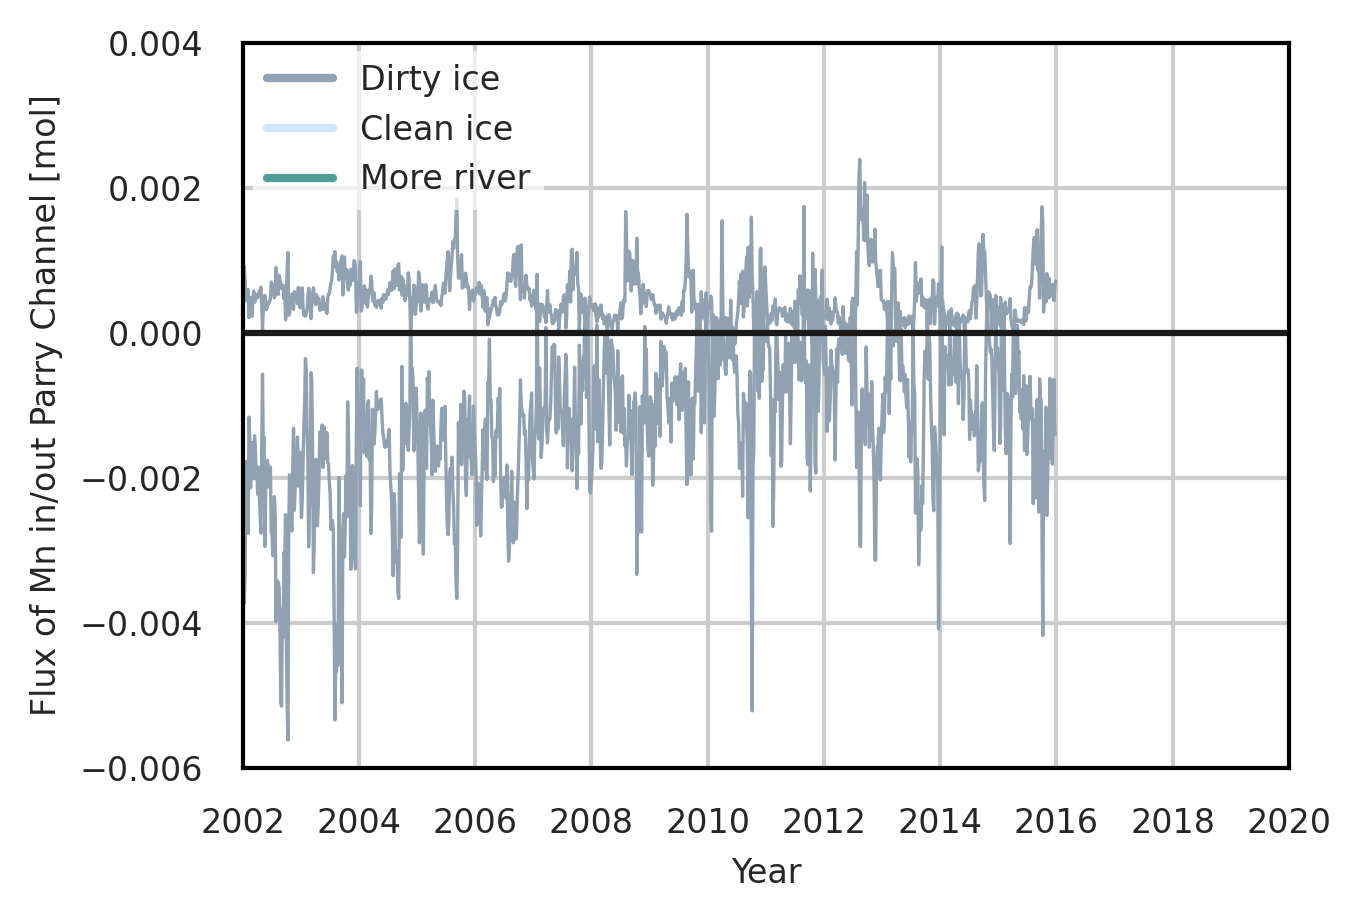

In [16]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates,      Parry_ref_in,    linewidth=0.8, color=dirty)
    sns.lineplot(dates,      -1*Parry_ref_out,   linewidth=0.8, color=dirty)
    
    sns.lineplot(dates[0],[0], linewidth=2, color=dirty, label=r'Dirty ice')
    sns.lineplot(dates[0],[0], linewidth=2, color=clean, label=r'Clean ice')
    sns.lineplot(dates[0],[0], linewidth=2, color=rivers, label=r'More river')

    sns.lineplot([dt.datetime(2002,1,1), dt.datetime(2020,1,1)], [0,0], c='k')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Flux of Mn in/out Parry Channel [mol]',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.006, 0.004))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.01, 0.77), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S13-flux-timeseries.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S13-flux-timeseries.svg', bbox_inches='tight', dpi=300, \
#             format='svg')

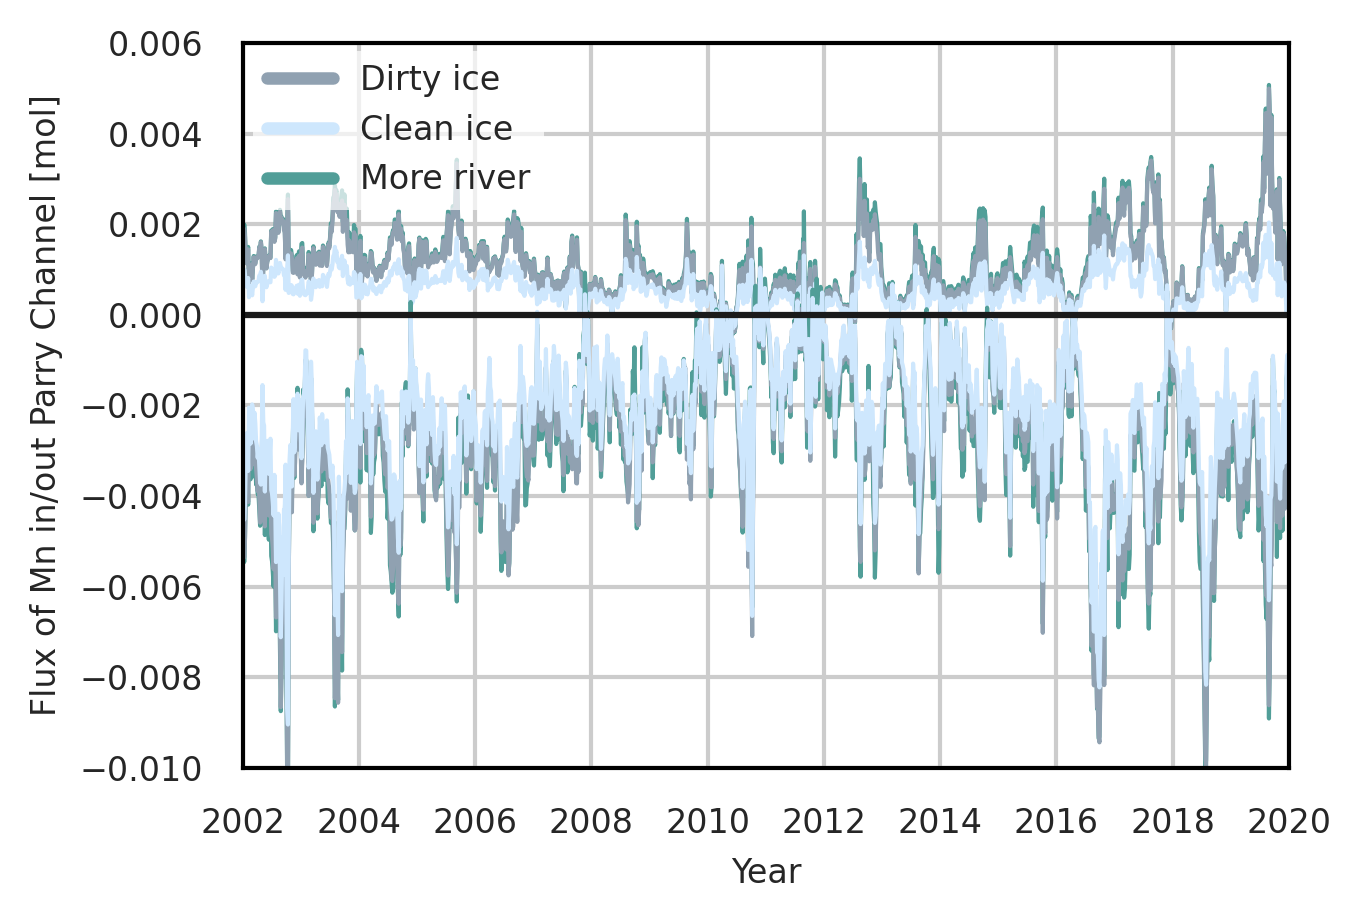

In [27]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_rivers_in,    linewidth=1.0, color=rivers, markersize=7)
    sns.lineplot(dates,      Parry_ref_in,       linewidth=1.0, color=dirty)
    sns.lineplot(dates,      Parry_nosed_in,     linewidth=1.0, color=clean, markersize=7)
    sns.lineplot(dates,      -1*Parry_rivers_out, linewidth=1.0, color=rivers)
    sns.lineplot(dates,      -1*Parry_ref_out,   linewidth=1.0, color=dirty)
    sns.lineplot(dates,      -1*Parry_nosed_out, linewidth=1.0, color=clean)
    
    sns.lineplot(dates[0],[0], linewidth=3, color=dirty, label=r'Dirty ice')
    sns.lineplot(dates[0],[0], linewidth=3, color=clean, label=r'Clean ice')
    sns.lineplot(dates[0],[0], linewidth=3, color=rivers, label=r'More river')

    sns.lineplot([dt.datetime(2002,1,1), dt.datetime(2020,1,1)], [0,0], c='k')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Flux of Mn in/out Parry Channel [mol]',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.01, 0.006))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.01, 0.77), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S13-flux-timeseries.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S13-flux-timeseries.svg', bbox_inches='tight', dpi=300, \
#             format='svg')

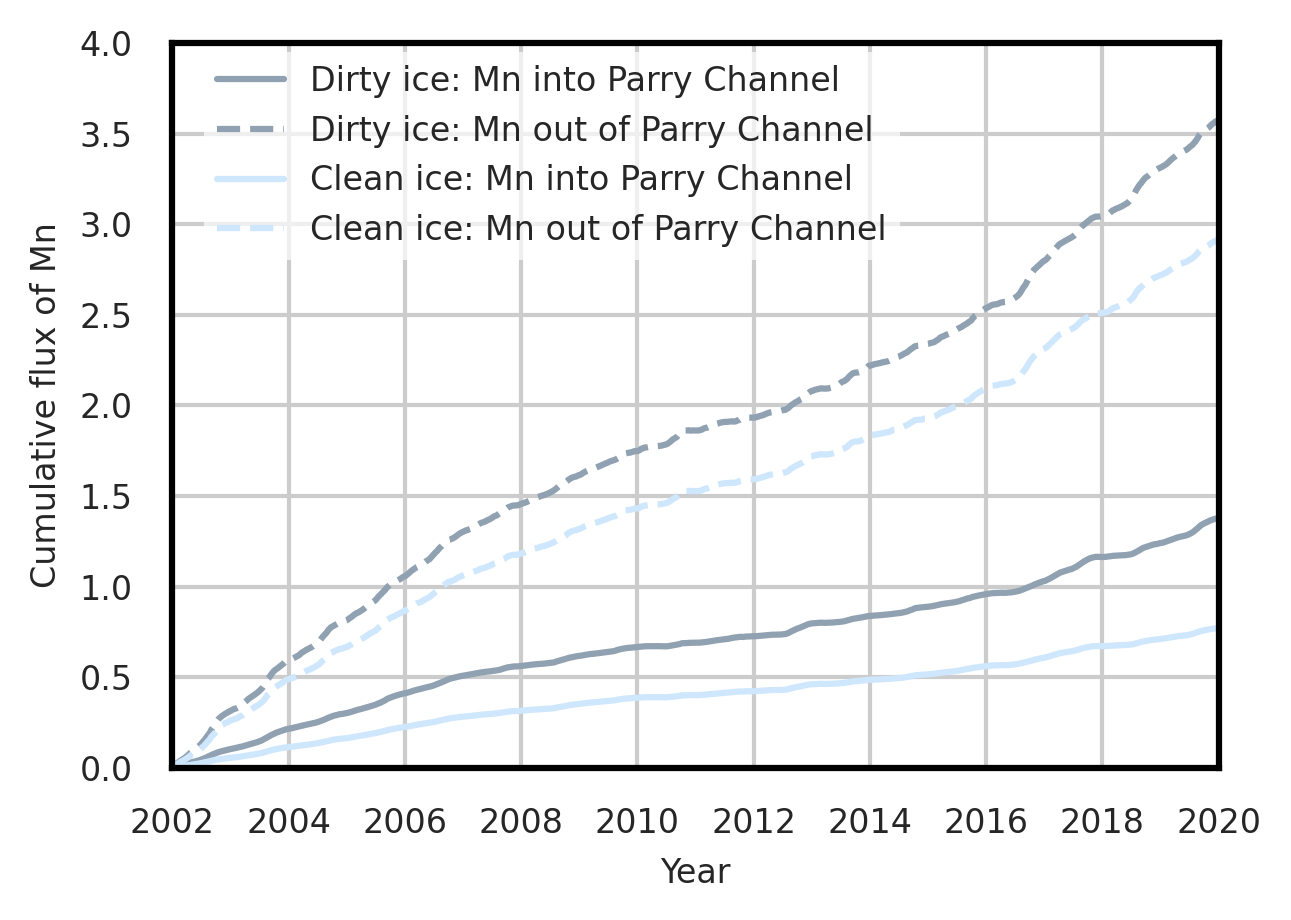

In [23]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_ref_cumsumin, linewidth=1.5, color=dirty, \
                      label=r'Dirty ice: Mn into Parry Channel')
    sns.lineplot(dates, Parry_ref_cumsumout, linewidth=1.5, color=dirty, \
                 label=r'Dirty ice: Mn out of Parry Channel')
    ax.lines[1].set_linestyle('--')
    
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], Parry_nosed_cumsumin, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn into Parry Channel')
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], Parry_nosed_cumsumout, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn out of Parry Channel')
    ax.lines[3].set_linestyle('--')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Cumulative flux of Mn',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 4.0))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.7), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/D2-Mn-flux-'+ \
#             str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

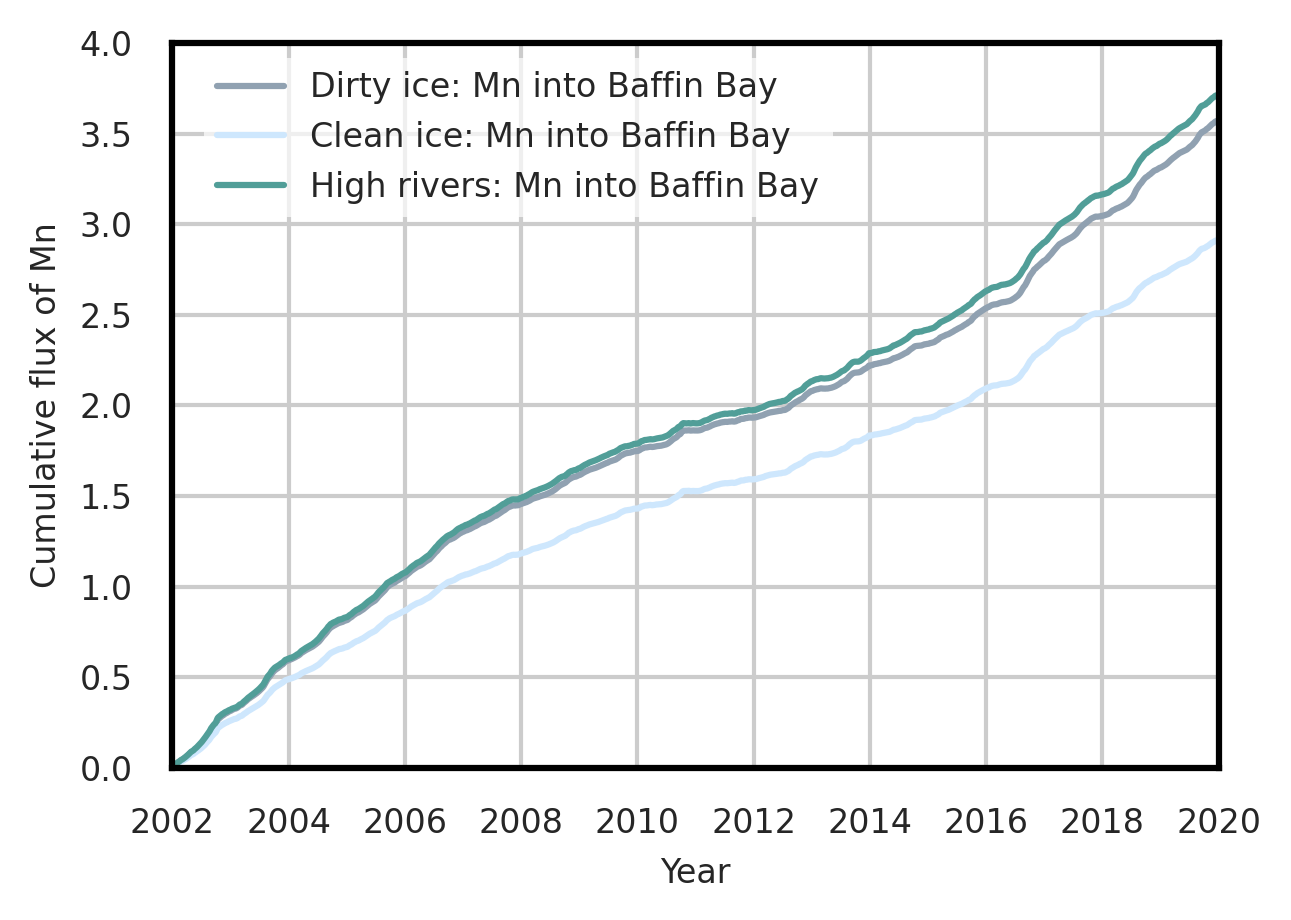

In [37]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_ref_cumsumout, linewidth=1.5, color=dirty, \
                      label=r'Dirty ice: Mn into Baffin Bay')
    
    sns.lineplot(dates[0:Parry_nosed_out.shape[0]], Parry_nosed_cumsumout, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn into Baffin Bay')
    sns.lineplot(dates[0:Parry_rivers_out.shape[0]], Parry_rivers_cumsumout, linewidth=1.5, color=rivers, \
                 label=r'High rivers: Mn into Baffin Bay')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Cumulative flux of Mn',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 4.0))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.76), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)

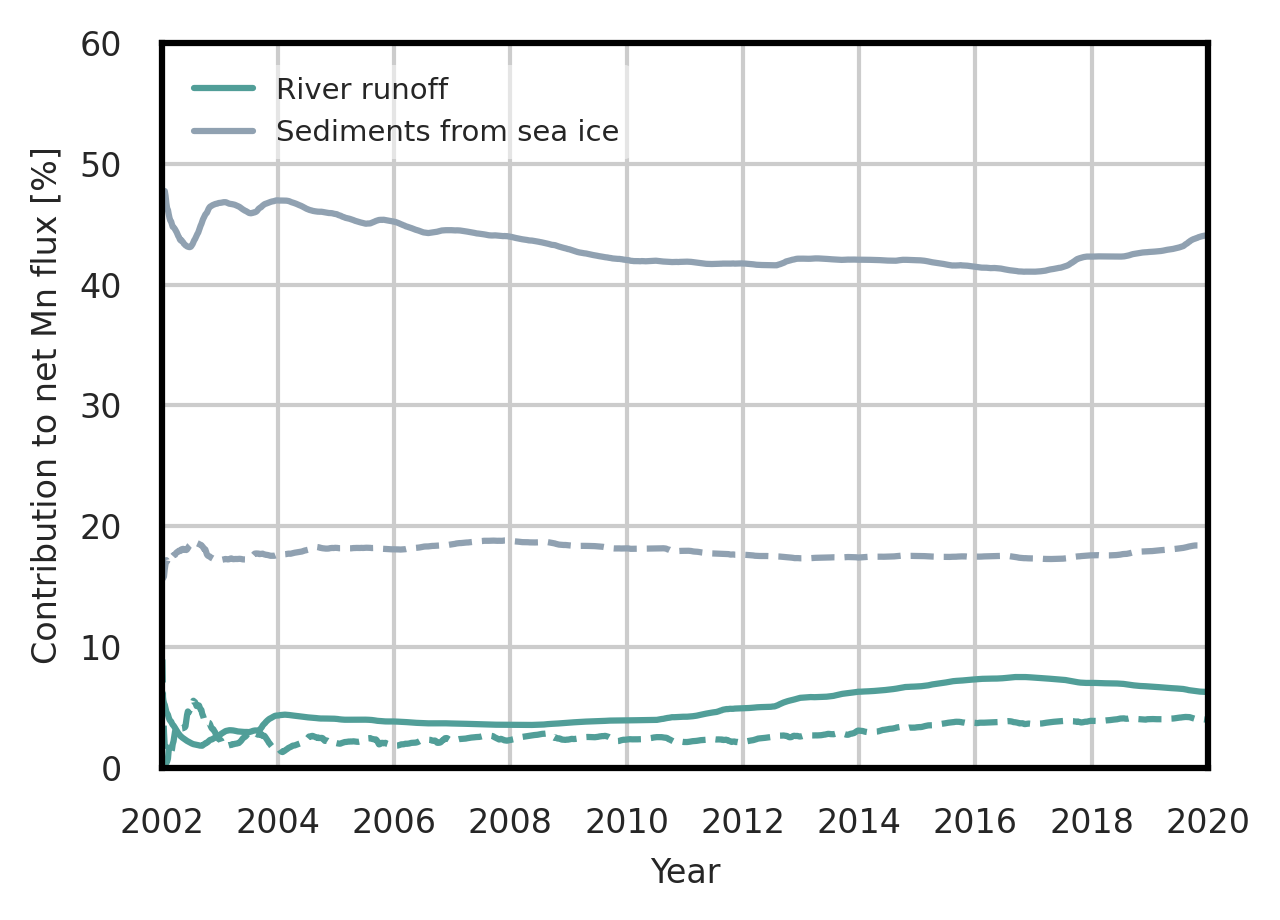

In [35]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                      (1-np.divide(Parry_nosed_cumsumin, Parry_ref_cumsumin[0:Parry_nosed_in.shape[0]]))*100, \
                      linewidth=1.5, color=dirty)
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                 (1-np.divide(Parry_nosed_cumsumout, Parry_ref_cumsumout[0:Parry_nosed_in.shape[0]]))*100, \
                 linewidth=1.5, color=dirty)
    sns.lineplot(dates[0:Parry_ref_in.shape[0]], \
                      -1*(1-np.divide(Parry_rivers_cumsumin, Parry_ref_cumsumin[0:Parry_ref_in.shape[0]]))*100, \
                      linewidth=1.5, color=rivers)
    sns.lineplot(dates[0:Parry_ref_in.shape[0]], \
                 -1*(1-np.divide(Parry_rivers_cumsumout, Parry_ref_cumsumout[0:Parry_ref_in.shape[0]]))*100, \
                 linewidth=1.5, color=rivers)
    ax.lines[1].set_linestyle('--')
    ax.lines[3].set_linestyle('--')
    
    sns.lineplot(dates[0], [0], linewidth=1.5, color=rivers, label='River runoff')
    sns.lineplot(dates[0], [0], linewidth=1.5, color=dirty, label='Sediments from sea ice')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Contribution to net Mn flux [%]',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 60))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black'); 
    
    leg = ax.legend(loc=(0.02, 0.84), frameon=True, framealpha=0.5, fontsize=7)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.svg', bbox_inches='tight', dpi=300, \
#             format='svg')

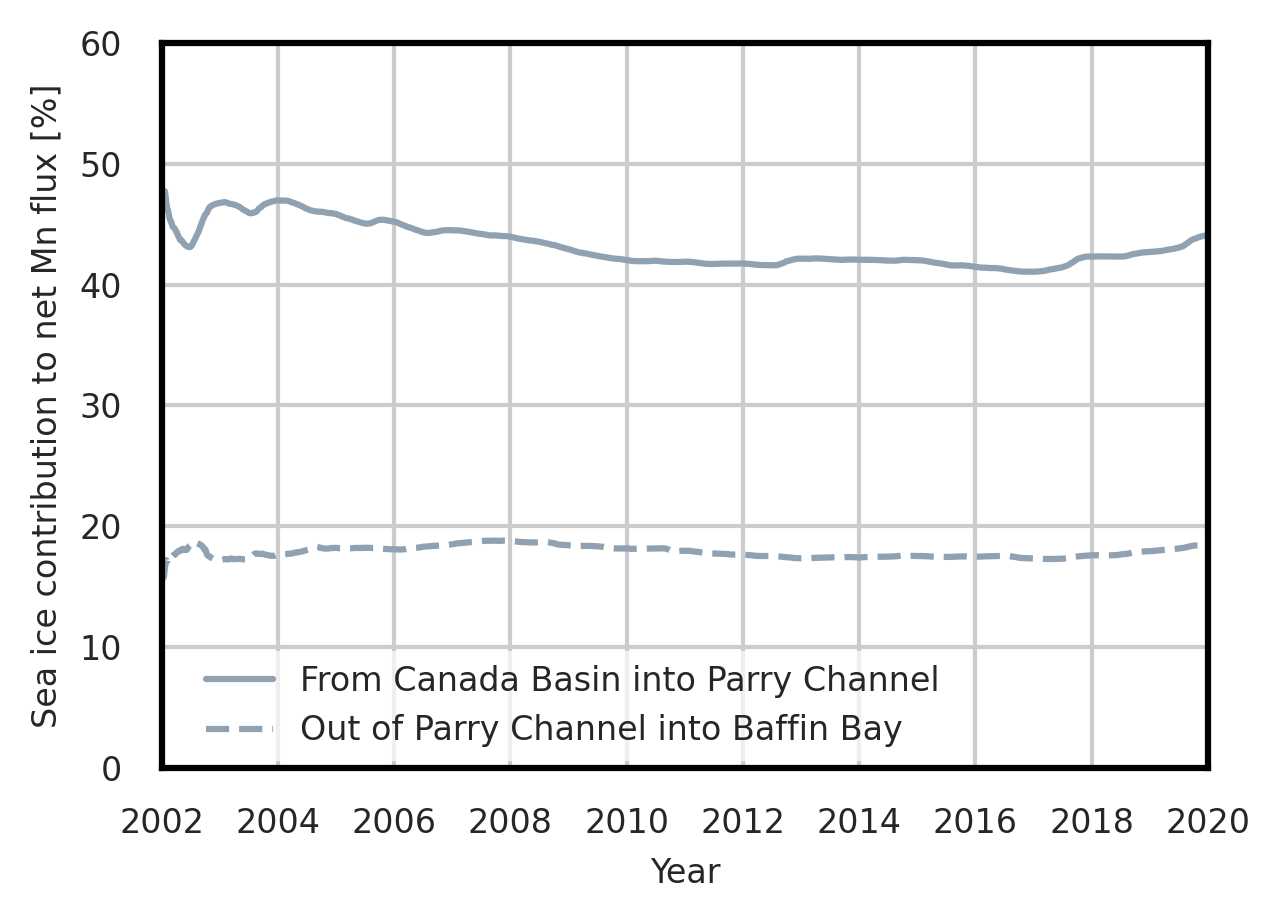

In [33]:
st  = sns.axes_style("whitegrid")

with st:
    fig = plt.figure(figsize=(4.5, 3.2), dpi=300)

    ax = sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                      (1-np.divide(Parry_nosed_cumsumin, Parry_ref_cumsumin[0:Parry_nosed_in.shape[0]]))*100, \
                      linewidth=1.5, color=dirty, label=r'From Canada Basin into Parry Channel')
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                 (1-np.divide(Parry_nosed_cumsumout, Parry_ref_cumsumout[0:Parry_nosed_in.shape[0]]))*100, \
                 linewidth=1.5, color=dirty, label=r'Out of Parry Channel into Baffin Bay')
    ax.lines[1].set_linestyle('--')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Sea ice contribution to net Mn flux [%]',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 60))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.01), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)
 
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/A9-flux-percentage.png', bbox_inches='tight', dpi=300)

### Plot the boundaries:

In [10]:
l1i = 2013-imin; l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin; l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin; l6j = np.arange(660-jmin,690-jmin)

t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin

r1i = 1520-imin; r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin; r2j = np.arange(385-jmin,405-jmin)

N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares Strait
P1i = 1585-imin; P1j = np.arange(485-jmin,538-jmin)  #Parry channel

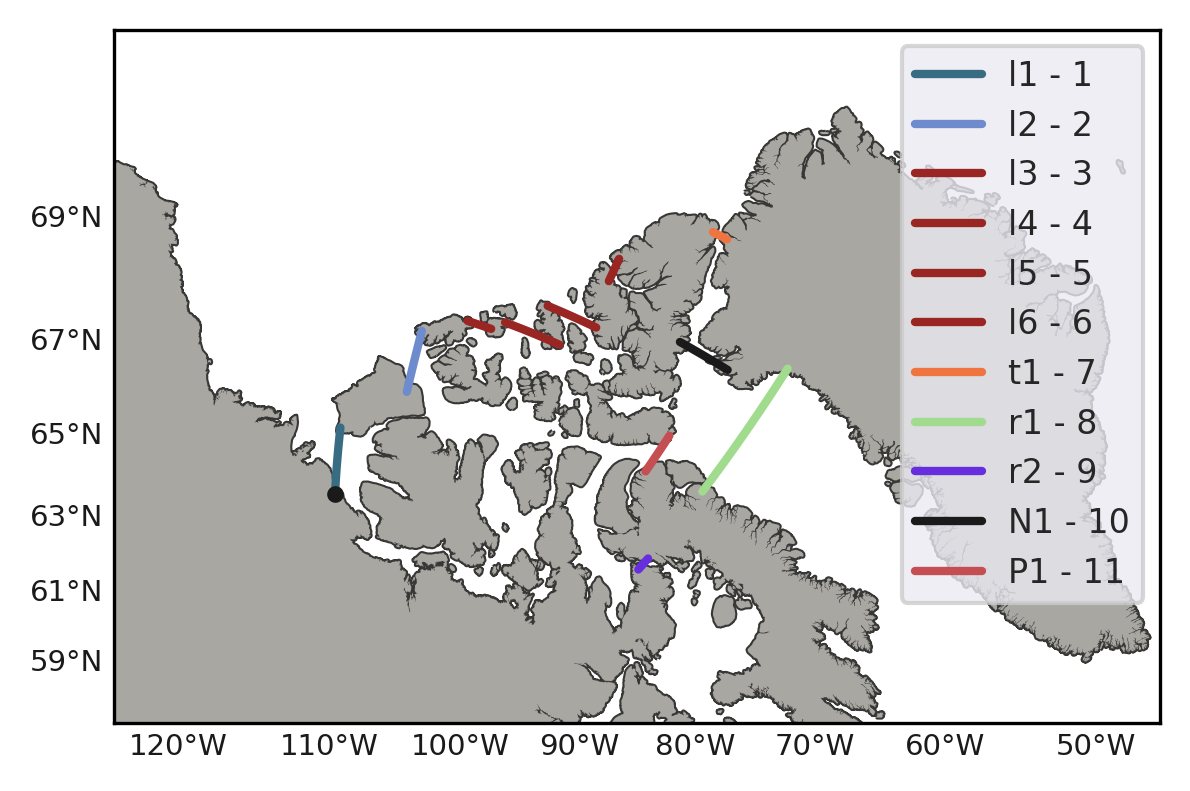

In [54]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

bdy_colours = ['#386c82','#6e8bce','#992622','#f07440','#a0db8e','#672edf']

x_model, y_model = proj1(lons[imin:imax,jmin:jmax], lats[imin:imax,jmin:jmax])
proj1.plot(x_model[l1i, l1j[0]:l1j[-1]], y_model[l1i, l1j[0]:l1j[-1]],'-', \
           c=bdy_colours[0], linewidth=2,zorder=4, label='l1 - 1') 
proj1.plot(x_model[l1i, l1j[0]], y_model[l1i, l1j[0]], '.k', zorder=4)
proj1.plot(x_model[l2i, l2j[0]:l2j[-1]], y_model[l2i, l2j[0]:l2j[-1]],'-', \
           c=bdy_colours[1], linewidth=2,zorder=4, label='l2 - 2') 
proj1.plot(x_model[l3i[0]:l3i[-1], l3j], y_model[l3i[0]:l3i[-1], l3j],'-', \
           c=bdy_colours[2], linewidth=2,zorder=4, label='l3 - 3') 
proj1.plot(x_model[l4i[0]:l4i[-1], l4j], y_model[l4i[0]:l4i[-1], l4j],'-', \
           c=bdy_colours[2], linewidth=2,zorder=4, label='l4 - 4')
proj1.plot(x_model[l5i[0]:l5i[-1], l5j], y_model[l5i[0]:l5i[-1], l5j],'-', \
           c=bdy_colours[2], linewidth=2,zorder=4, label='l5 - 5')
proj1.plot(x_model[l6i, l6j[0]:l6j[-1]], y_model[l6i, l6j[0]:l6j[-1]],'-', \
           c=bdy_colours[2], linewidth=2,zorder=4, label='l6 - 6')
proj1.plot(x_model[t1i[0]:t1i[-1], t1j], y_model[t1i[0]:t1i[-1], t1j],'-', \
           c=bdy_colours[3], linewidth=2,zorder=4, label='t1 - 7') 
proj1.plot(x_model[r1i, r1j[0]:r1j[-1]], y_model[r1i, r1j[0]:r1j[-1]],'-', \
           c=bdy_colours[4], linewidth=2,zorder=4, label='r1 - 8') 
proj1.plot(x_model[r2i, r2j[0]:r2j[-1]], y_model[r2i, r2j[0]:r2j[-1]],'-', \
           c=bdy_colours[5], linewidth=2,zorder=4, label='r2 - 9')  

proj1.plot(x_model[N1i[0]:N1i[-1], N1j], y_model[N1i[0]:N1i[-1], N1j],'-', \
           c='k', linewidth=2, zorder=4, label='N1 - 10') 
proj1.plot(x_model[P1i, P1j[0]:P1j[-1]], y_model[P1i, P1j[0]:P1j[-1]],'-', \
           c='r', linewidth=2, zorder=4, label='P1 - 11') 

ax1.legend(fontsize=8)

# Check volume conservation and volume fluxes relative to other studies:

In [15]:
volume_in_CAA   = np.empty([])
volume_Nares    = np.empty([])
volume_McClure  = np.empty([])
volume_Amundsen = np.empty([])
for year in years:
    ts_V1, ts_V2, ts_V3, ts_V4, ts_V5, ts_V6, \
        ts_V7, ts_V8, ts_V9, ts_V10, ts_V11 = check_volume_conservation(year)
    
    volume_in_CAA =  np.append(volume_in_CAA, \
                 -1*np.sum(ts_V1,axis=(1,2)) + \
                 -1*np.sum(ts_V2,axis=(1,2)) + \
                 -1*np.sum(ts_V3,axis=(1,2)) + \
                 -1*np.sum(ts_V4,axis=(1,2)) + \
                 -1*np.sum(ts_V5,axis=(1,2)) + \
                 -1*np.sum(ts_V6,axis=(1,2)) + \
                 -1*np.sum(ts_V7,axis=(1,2)) + \
                 np.sum(ts_V8,axis=(1,2)) + \
                 np.sum(ts_V9,axis=(1,2)))
    
    volume_Nares    = np.append(volume_Nares,    np.sum(ts_V7,axis=(1,2)))
    volume_McClure  = np.append(volume_McClure,  np.sum(ts_V2,axis=(1,2)))
    volume_Amundsen = np.append(volume_Amundsen, np.sum(ts_V1,axis=(1,2)))

In [16]:
print(f'Mean volume flux across boundary over 2003-2016: ')
print(f'Nares Strait:    {np.nanmean(volume_Nares*1e-6):.2f} Sv') 
print(f'McClure Strait:  {np.nanmean(volume_McClure*1e-6):.2f} Sv') 
print(f'Amundson Gulf:   {np.mean(volume_Amundsen*1e-6):.2f} Sv') 

Mean volume flux across boundary over 2003-2016: 
Nares Strait:    -0.91 Sv
McClure Strait:  -0.42 Sv
Amundson Gulf:   -0.05 Sv


These numbers are very similar to Grivault et al. (2018) who has similar boundaries and estimates volume flux in ANHA12.
The time series of fluxes in Nares Strait below also compares well with those in the above study.

Text(0.5, 1.0, 'Nares Strait')

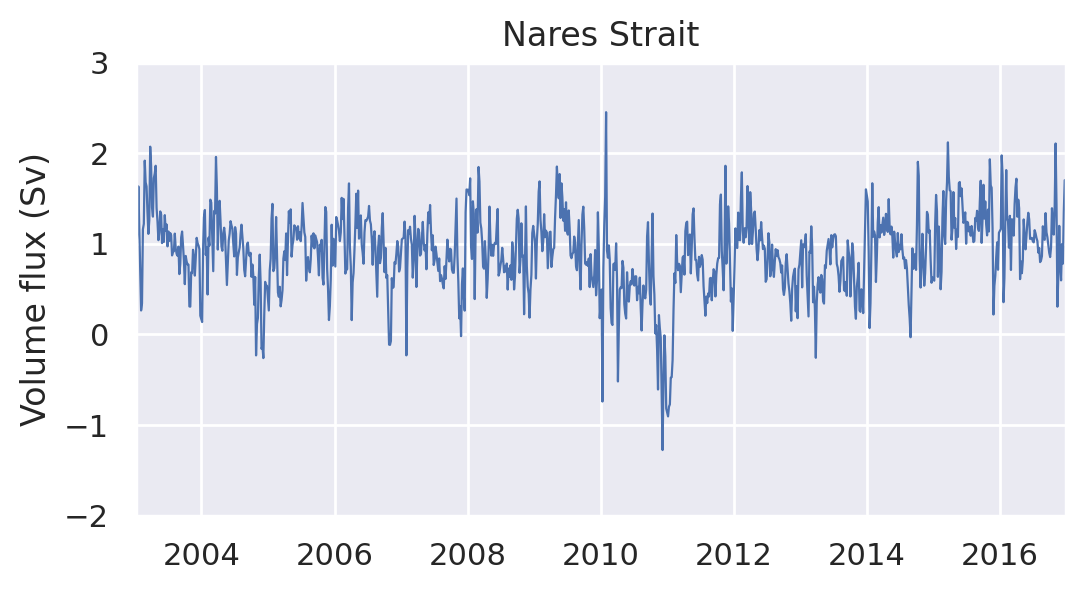

In [56]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
ax.plot(dates, -1*volume_Nares[0:-1]*1e-6, linewidth=0.8)
ax.set_xlim(dates[0], dates[-1])
ax.set_ylim([-2, 3])
ax.set_ylabel('Volume flux (Sv)')
ax.set_title('Nares Strait')

In [57]:
# # Horizontal cross sections: into CAA is postive, out of CAA is negative
# # ... these are: l3, l4, l5, t1, N1
# # ... on map directions: up = +, down = -
# # .... so: l3 (-1), l4 (-1), l5 (-1), t1 (-1), N1 (-1) for volume conservation
# # Vertical cross sections: into CAA is negative, out of CAA is positive
# # ... these are: l1, l2, l6, r1, r2, P1
# # ... on map directions: left = +, right = -
# # ... so l1 (-1), l2 (-1), l6 (x), r1 (1), r2 (1), P1 (1)

# volume_in_CAA =  -1*np.sum(ts_V1,axis=(1,2)) + \
#                  -1*np.sum(ts_V2,axis=(1,2)) + \
#                  -1*np.sum(ts_V3,axis=(1,2)) + \
#                  -1*np.sum(ts_V4,axis=(1,2)) + \
#                  -1*np.sum(ts_V6,axis=(1,2)) + \
#                  -1*np.sum(ts_V5,axis=(1,2)) + \
#                  -1*np.sum(ts_V7,axis=(1,2)) + \
#                  np.sum(ts_V8,axis=(1,2)) + \
#                  np.sum(ts_V9,axis=(1,2))       # l1 + l2 + l3 + l4 + l5 + t1 + r1 + r2

Text(0.5, 1.0, 'CAA')

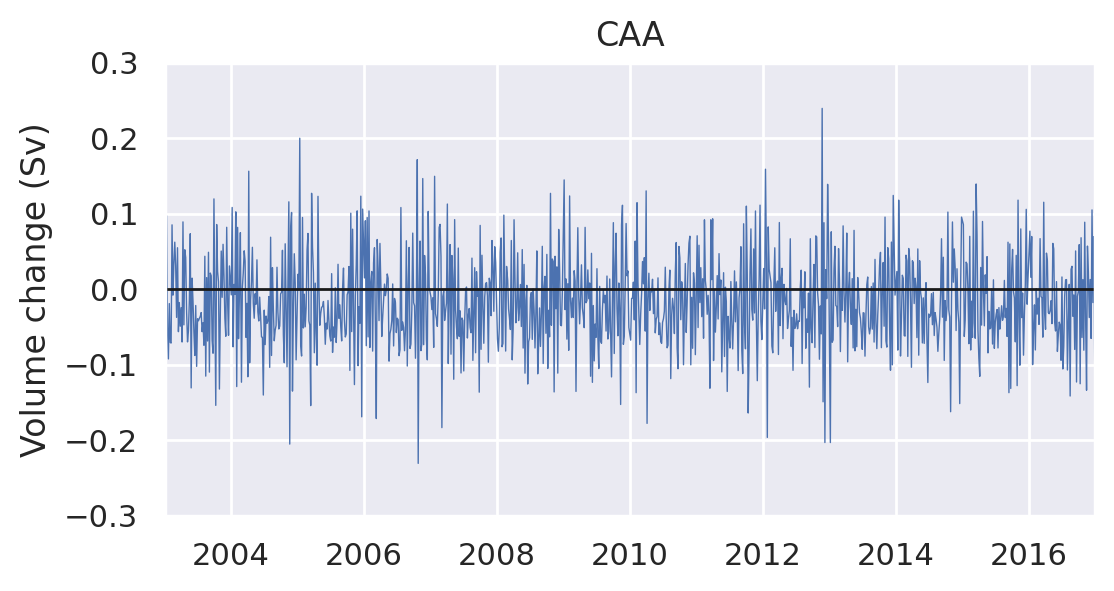

In [59]:
fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=200)
ax.plot(dates, volume_in_CAA[0:-1]*1e-6, linewidth=0.5)
ax.plot([dates[0], dates[-1]], [0, 0], '-k', linewidth=1.0)
ax.set_xlim(dates[0], dates[-1])
ax.set_ylim([-0.3, 0.3])
ax.set_ylabel('Volume change (Sv)')
ax.set_title('CAA')

Doesn't include river runoff and sea ice melt volume contributions.

In [17]:
# Area of grid cells:
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
e1t_base  = np.array(mesh.variables['e1t'])[0,imin-1:imax-1,jmin-1:jmax-1]
e2t_base  = np.array(mesh.variables['e2t'])[0,imin-1:imax-1,jmin-1:jmax-1]
e3t  = np.array(mesh.variables['e3t_0'])[0,:,:,:]

area = e1t_base*e2t_base

In [18]:
# Find indices to separate out Canada Basin:

x_ind = np.arange(1560, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700 -40

CB_indx = []; CB_indy = [];
for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)
    
# Separate Canada Basin and the CAA:
mask_ini_CAA = np.ones((isize,jsize))
for i, j in zip(CB_indx, CB_indy):
    try:
        mask_ini_CAA[int(i-imin),int(j-jmin)] = 0
    except:
        pass

mask_ini_CAA[0:r1i-3,:] = 0

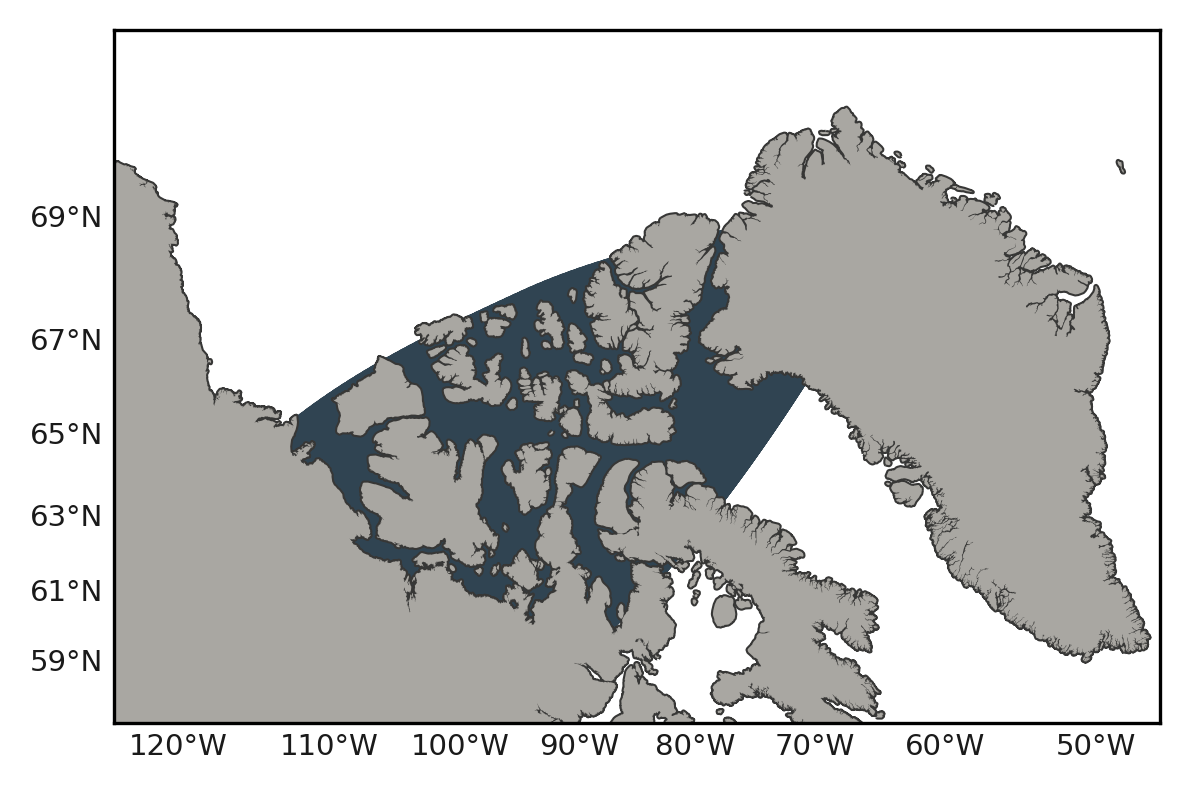

In [185]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(lons[imin:imax,jmin:jmax], lats[imin:imax,jmin:jmax]) 

# Draw domain boundaries:
proj1.plot(np.ma.masked_where(mask_ini_CAA==0  , x_sub), np.ma.masked_where(mask_ini_CAA==0  , y_sub),\
           '-', color='#304452', linewidth=10, zorder=1);

In [19]:
# Estimate contribution from river runoff:
rnf_2003    = nc.Dataset('/ocean/brogalla/GEOTRACES/data/runoff/'+\
                         'ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y2003.nc')
runoff      = np.array(rnf_2003.variables['runoff'])[:,imin-1:imax-1,jmin-1:jmax-1] # kg/s/m2

runoff_sub  = np.copy(runoff) 
mrunoff_sub = runoff_sub*mask_ini_CAA*area*1e-3 # units of runoff are kg / m2 / s --> kg / s --> m3 / s
number_days = [monthrange(2003,month)[1] for month in range(1,13)] # number of days in each month

In [24]:
# volume = melt rate (m/s) * grid cell area within CAA * time
iceprod = np.zeros(lons.shape)
for month in range(1,13):
    file     = nc.Dataset(f'/data/brogalla/ANHA12/icemod_ave/ANHA12-EXH006_icemod_y2003m{month:02}.nc')
    numdays  = monthrange(2003, month)[1]
#     ice_melt = np.array(file.variables['iiceprod'][0,:,:])
#     ice_melt[ice_melt > 0] = 0
    ice_vol  = np.array(file.variables['iiceprod'][0,:,:])
    iceprod  = iceprod + ice_vol*numdays*3600*24/180 # units of m/kt --> m/month
#     iceprod  = iceprod + ice_melt*numdays*3600*24/180 # units of m/kt --> m/month
    # summed over months so m/year
    
iceprod_sub = iceprod[imin-1:imax-1,jmin-1:jmax-1]*mask_ini_CAA*area/(3600*24*365) # m3 / s

In [25]:
print(f'Volume change in CAA over year 2003: {np.nansum(volume_in_CAA[0:72]*5*3600*24)*1e-6/(3600*24*365):.2f} Sv')
print(f'Unaccounted for volume additions: ')
print(f'- River runoff: {np.sum(np.sum(mrunoff_sub, axis=(1,2))*3600*24*number_days)*1e-6/(3600*24*365):.2f} Sv')
print(f'- Sea ice melt: {-1*np.sum(iceprod_sub, axis=(0,1))*1e-6:.2f} Sv')

Volume change in CAA over year 2003: -0.02 Sv
Unaccounted for volume additions: 
- River runoff: 0.01 Sv
- Sea ice melt: -0.02 Sv


### Have a look at cross-sections

In [21]:
def calc_distance(i,j):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats[i,j]]
    lons_rad = [radians(l) for l in lons[i,j]]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [22]:
distance_V1 = calc_distance(l1i, np.arange(l1j[0]+jmin, l1j[-1]+jmin, 1))
distance_V2 = calc_distance(l2i, np.arange(l2j[0]+jmin, l2j[-1]+jmin, 1))
distance_V3 = calc_distance(np.arange(l3i[0]+imin, l3i[-1]+imin, 1), l3j)
distance_V4 = calc_distance(np.arange(l4i[0]+imin, l4i[-1]+imin, 1), l4j)
distance_V5 = calc_distance(np.arange(l5i[0]+imin, l5i[-1]+imin, 1), l5j)

distance_V7 = calc_distance(np.arange(t1i[0]+imin, t1i[-1]+imin, 1), t1j)
distance_V8  = calc_distance(r1i, np.arange(r1j[0]+jmin, r1j[-1]+jmin, 1))
distance_V9  = calc_distance(r2i, np.arange(r2j[0]+jmin, r2j[-1]+jmin, 1))
distance_V10 = calc_distance(np.arange(N1i[0]+imin, N1i[-1]+imin, 1), N1j)
distance_V11 = calc_distance(P1i, np.arange(P1j[0]+jmin, P1j[-1]+jmin, 1))

In [23]:
V1 = np.ma.masked_where((tmask[:,l1i,l1j[0]:l1j[-1]] < 0.1), np.sum(ts_V1, axis=0))
V2 = np.ma.masked_where((tmask[:,l2i,l2j[0]:l2j[-1]] < 0.1), np.sum(ts_V2, axis=0))
V3 = np.ma.masked_where((tmask[:,l3i[0]:l3i[-1],l3j] < 0.1), np.sum(ts_V3, axis=0))
V4 = np.ma.masked_where((tmask[:,l4i[0]:l4i[-1],l4j] < 0.1), np.sum(ts_V4, axis=0))
V5 = np.ma.masked_where((tmask[:,l5i[0]:l5i[-1],l5j] < 0.1), np.sum(ts_V5, axis=0))

V7 = np.ma.masked_where((tmask[:,t1i[0]:t1i[-1],t1j] < 0.1), np.sum(ts_V7, axis=0))
V8 = np.ma.masked_where((tmask[:,r1i,r1j[0]:r1j[-1]] < 0.1), np.sum(ts_V8, axis=0))
V9 = np.ma.masked_where((tmask[:,r2i,r2j[0]:r2j[-1]] < 0.1), np.sum(ts_V9, axis=0))

V10 = np.ma.masked_where((tmask[:,N1i[0]:N1i[-1], N1j] < 0.1), np.sum(ts_V10, axis=0))
V11 = np.ma.masked_where((tmask[:,P1i,P1j[0]:P1j[-1]] < 0.1), np.sum(ts_V11, axis=0))

In [119]:
def plot_XS(distance, depths, volume, vmin=-5e5, vmax=5e5, ylim=(3000,0), title=''):

    fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
    ax.invert_yaxis()
    CS1 = ax.contourf(distance, depths, volume, vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance)
    ax.set_ylim([ylim[0], ylim[-1]])

    cbaxes = fig.add_axes([0.91, 0.12, 0.04, 0.76]) 
    CBar   = fig.colorbar(CS1, cax=cbaxes)
    ax.set_title(title)
    return

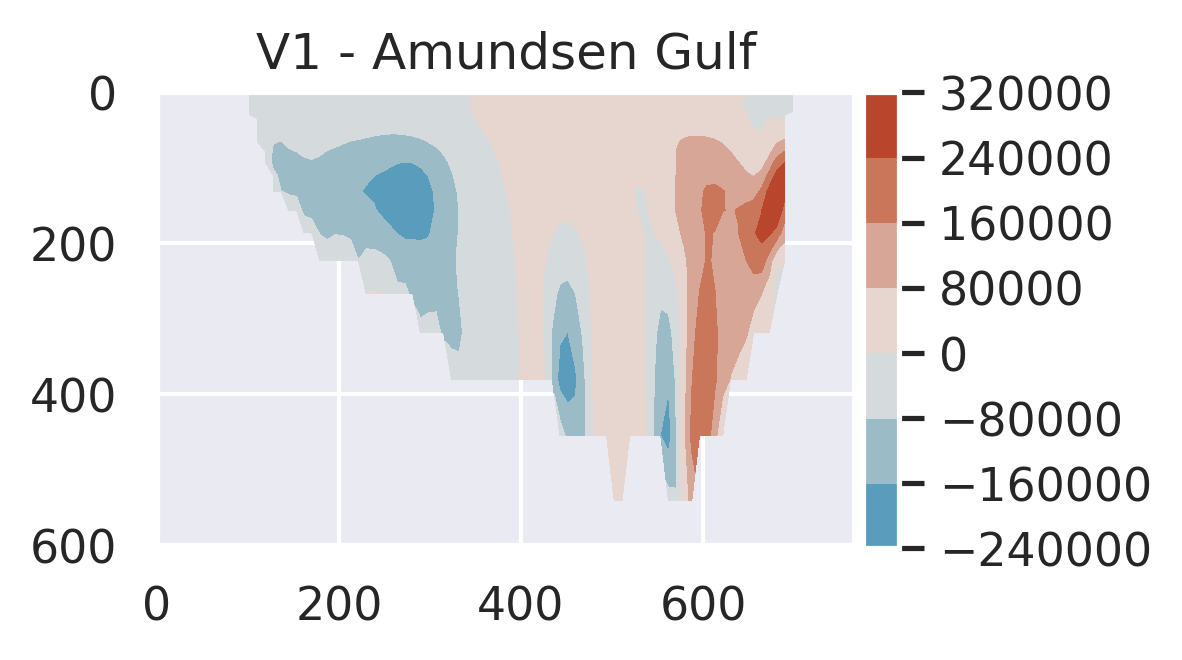

In [151]:
plot_XS(distance_V1, depths, V1, vmin=-5e5, vmax=5e5, ylim=(600,0), title='V1 - Amundsen Gulf')

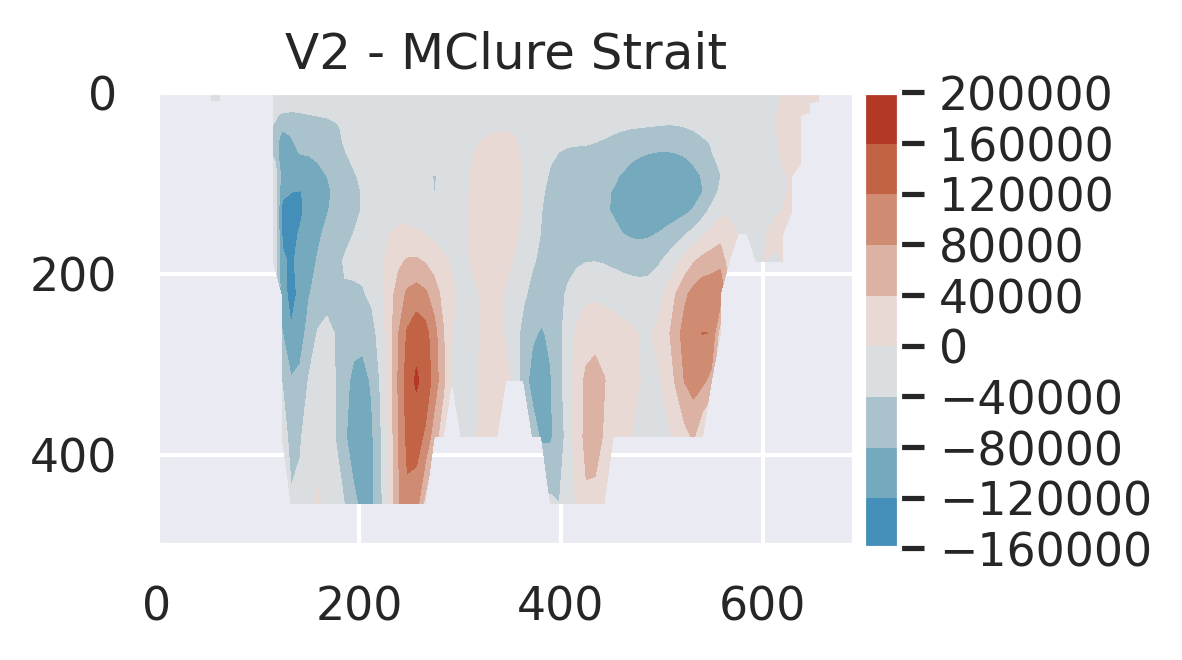

In [131]:
plot_XS(distance_V2, depths, V2, vmin=-3e5, vmax=3e5, ylim=(500,0), title='V2 - MClure Strait')

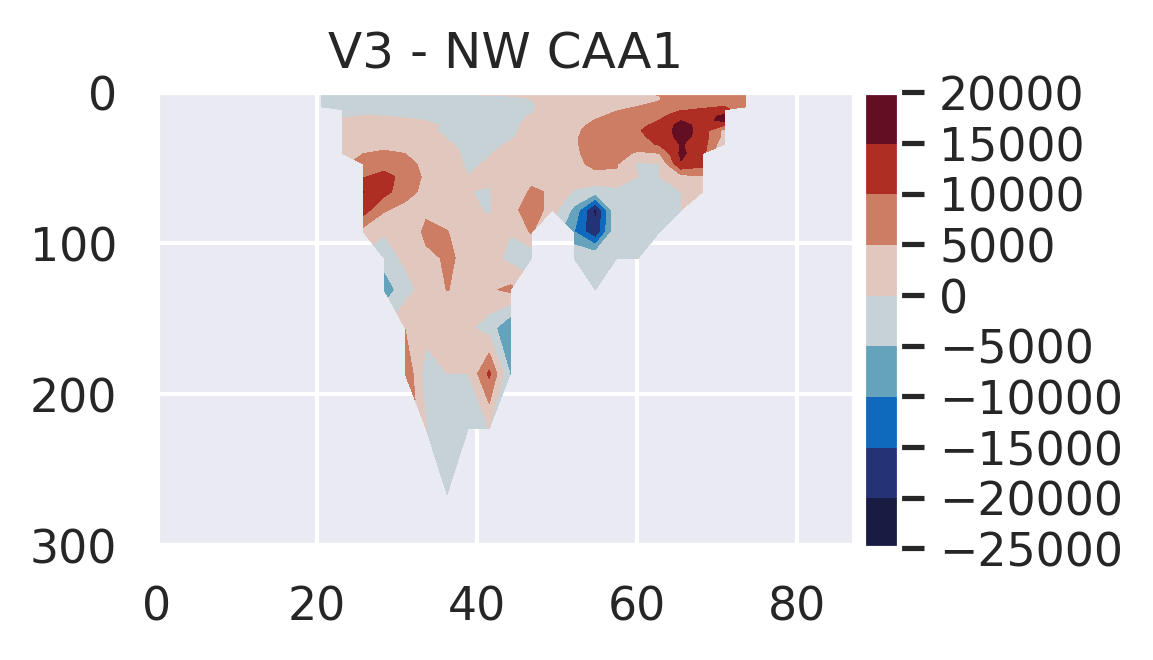

In [135]:
plot_XS(distance_V3, depths, V3, vmin=-2e4, vmax=2e4, ylim=(300,0), title='V3 - NW CAA1')

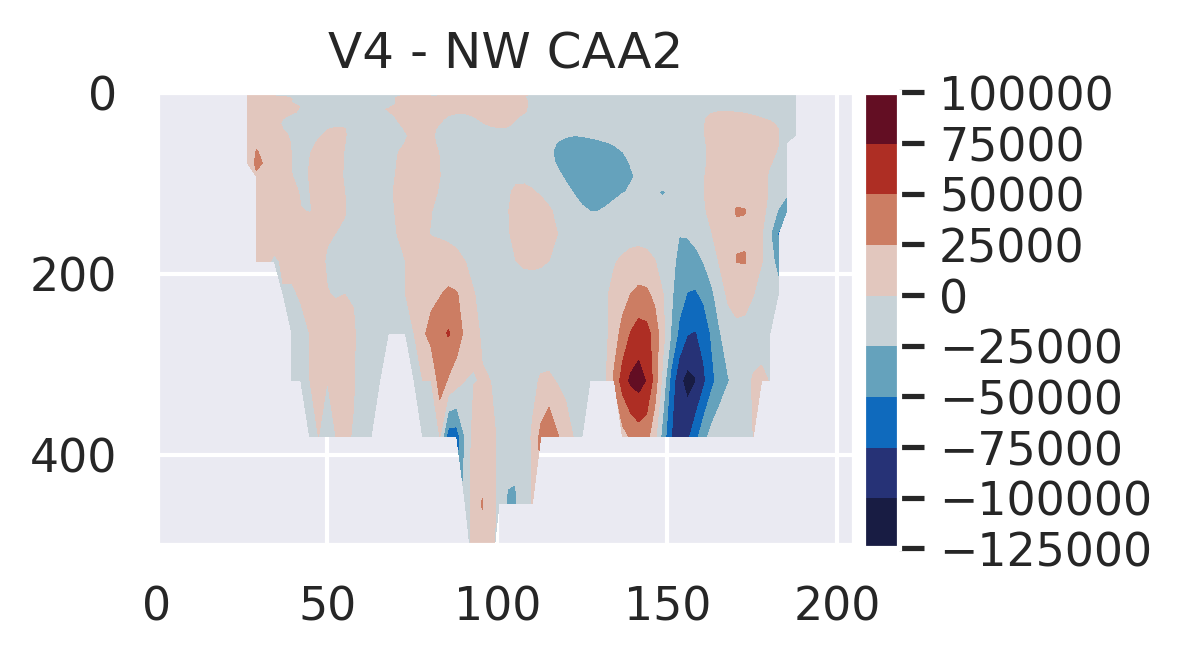

In [137]:
plot_XS(distance_V4, depths, V4, vmin=-1e5, vmax=1e5, ylim=(500,0), title='V4 - NW CAA2')

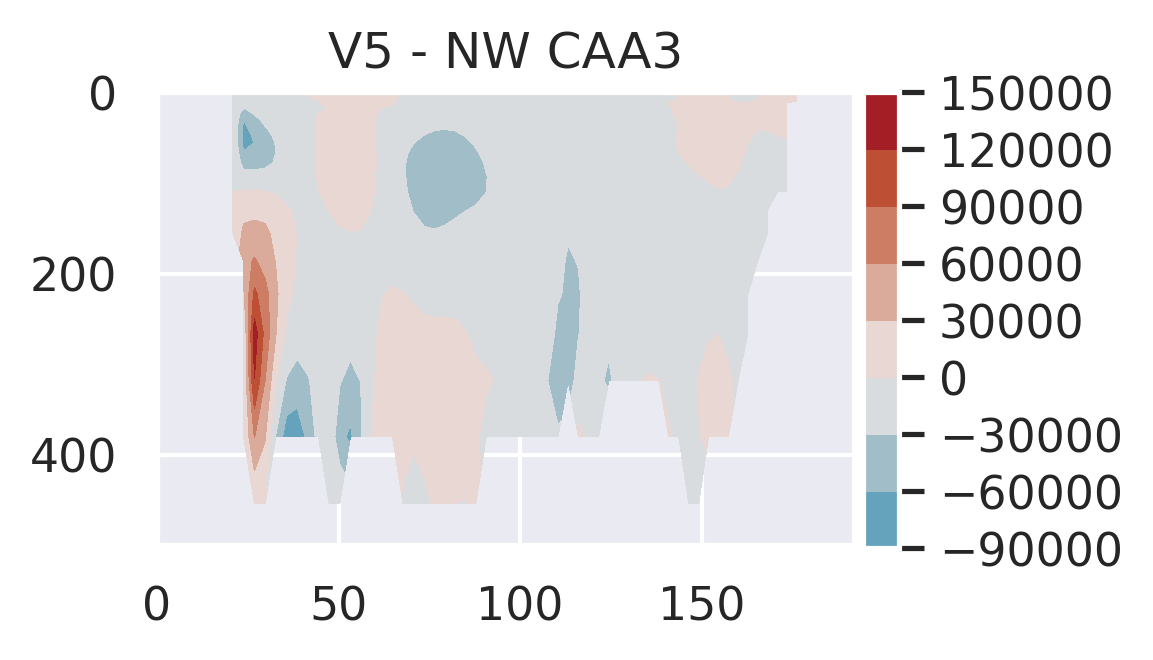

In [140]:
plot_XS(distance_V5, depths, V5, vmin=-2e5, vmax=2e5, ylim=(500,0), title='V5 - NW CAA3')

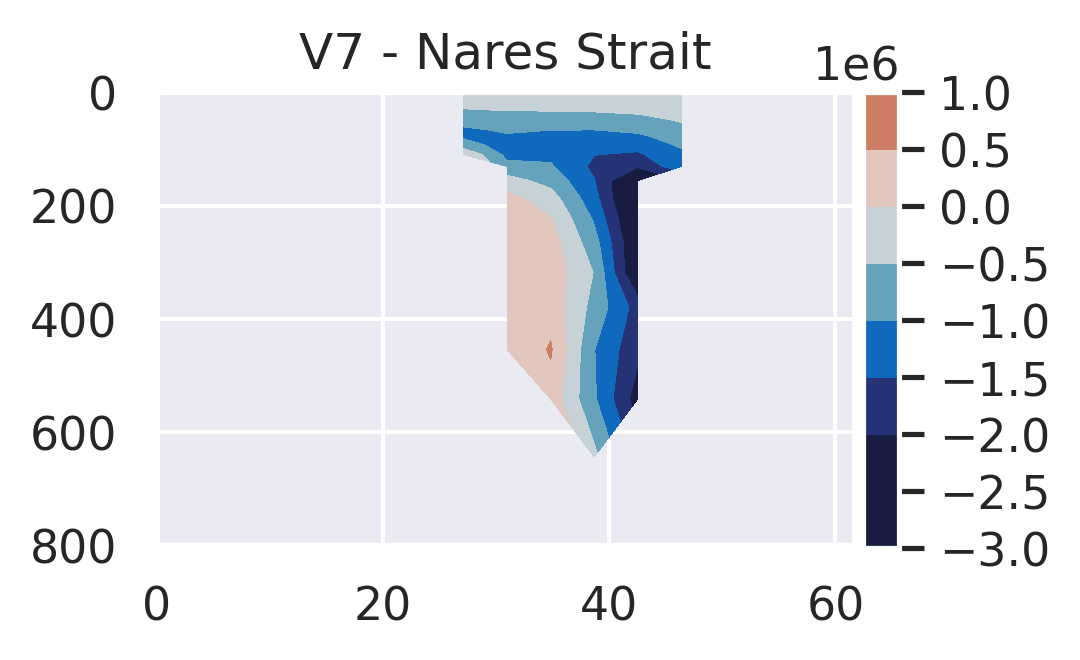

In [143]:
plot_XS(distance_V7, depths, V7, vmin=-2e6, vmax=2e6, ylim=(800,0), title='V7 - Nares Strait')

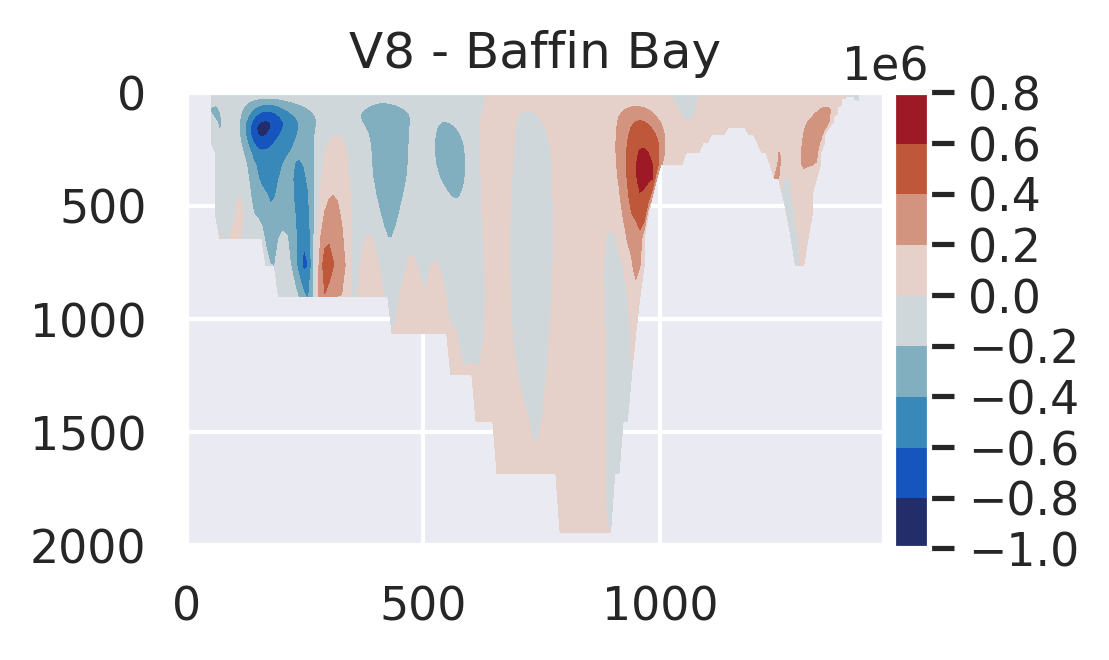

In [125]:
plot_XS(distance_V8, depths, V8, vmin=-1e6, vmax=1e6, ylim=(2000,0), title='V8 - Baffin Bay')

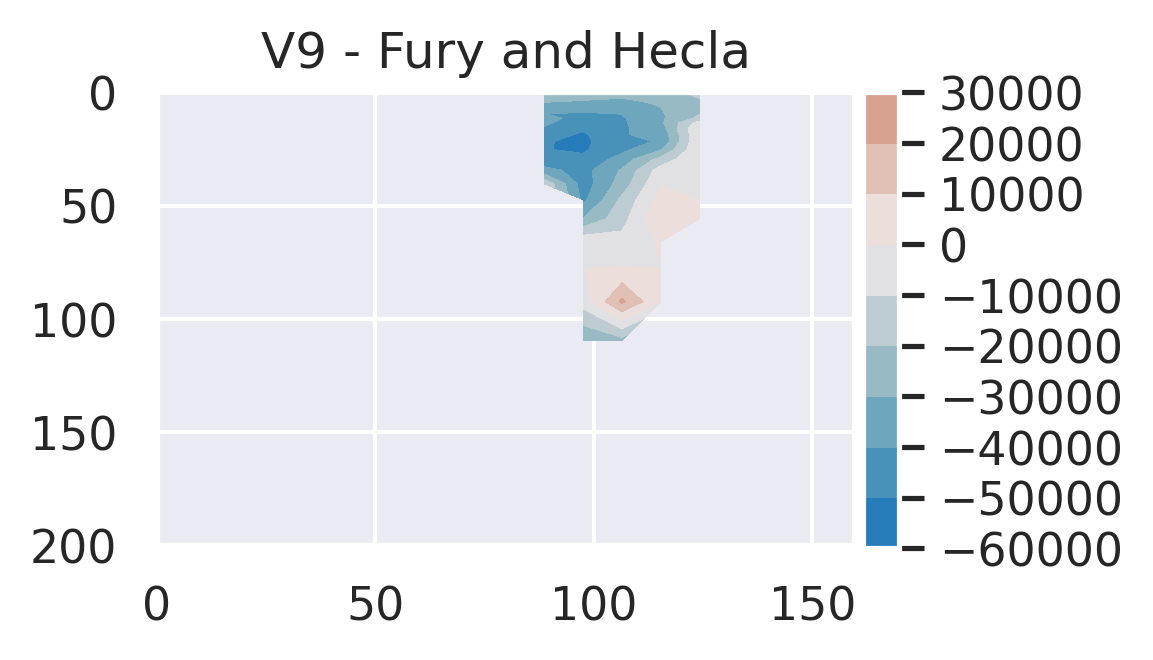

In [124]:
plot_XS(distance_V9, depths, V9, vmin=-1e5, vmax=1e5, ylim=(200,0), title='V9 - Fury and Hecla')

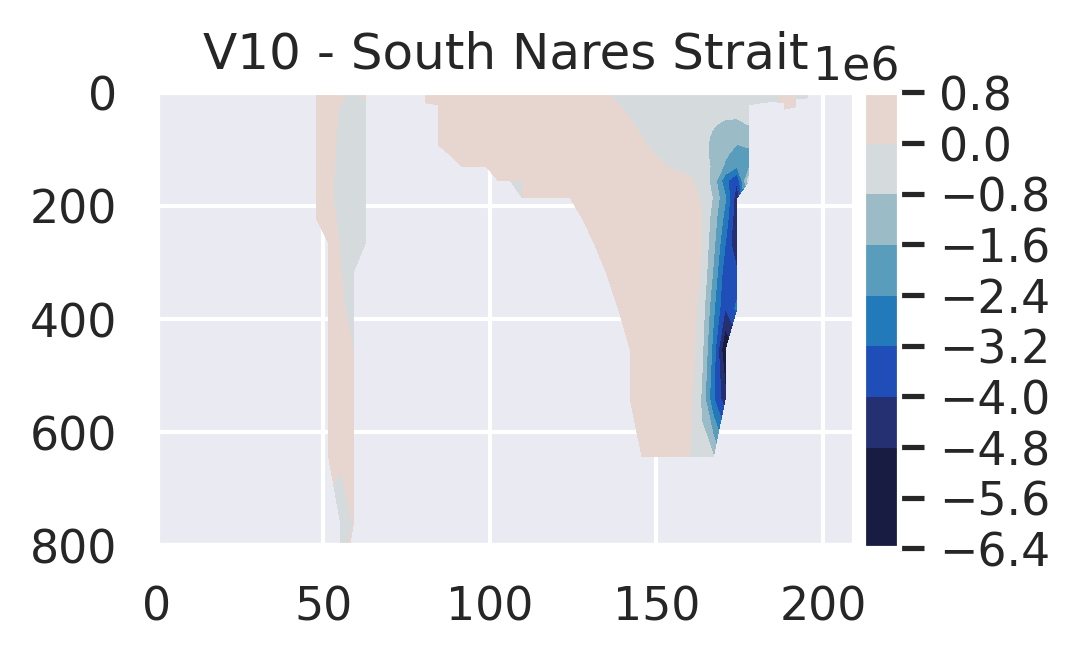

In [150]:
plot_XS(distance_V10, depths, V10, vmin=-5e6, vmax=5e6, ylim=(800,0), title='V10 - South Nares Strait')

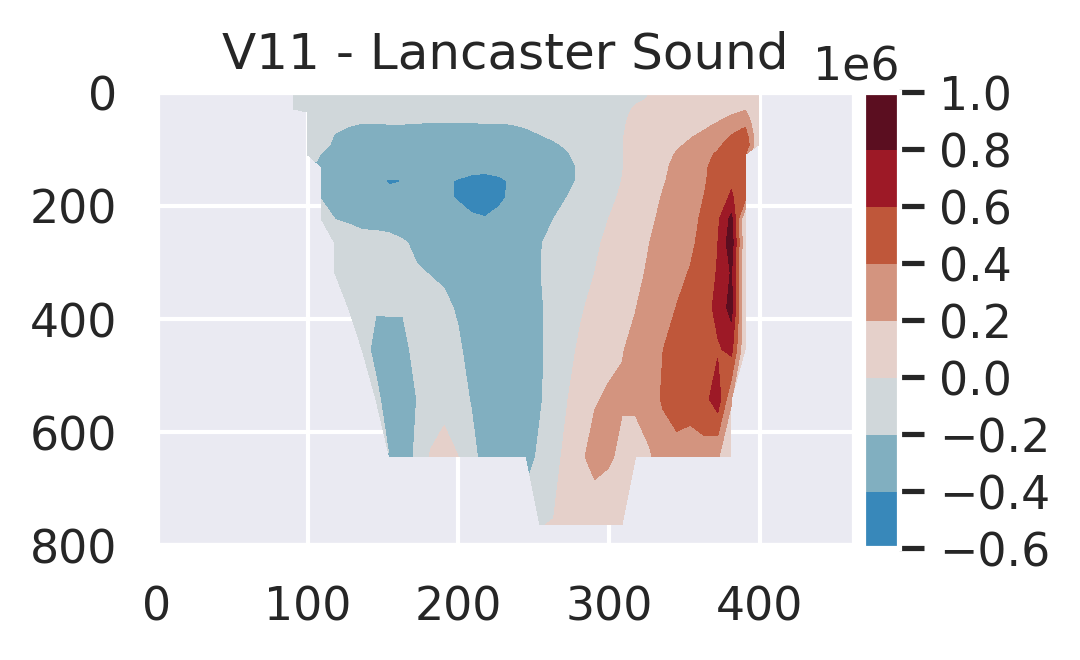

In [153]:
plot_XS(distance_V11, depths, V11, vmin=-1e6, vmax=1e6, ylim=(800,0), title='V11 - Lancaster Sound')

#### Double-check landmasking:

In [141]:
# Load files:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask.nc')
tmask = np.array(mask.variables['tmask'])[0,:,:,:]
tmask_sub = np.array(mask.variables['tmask'])[0,:,imin-1:imax-1,jmin-1:jmax-1]
cond_mask_sub = (tmask_sub[:,:,:] < 0.1)

In [142]:
dmn_file = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2015_20211012/'+\
                      'ANHA12_EXH006_2015_monthly.nc')

dmn_2015 = np.array(dmn_file.variables['dissolmn'])[7,0,:,:,:]

In [143]:
dmn_2015.shape 
#cond_mask_sub = (tmask_sub[:,r1i, r1j[0]:r1j[-1]] < 0.1)

(50, 700, 640)

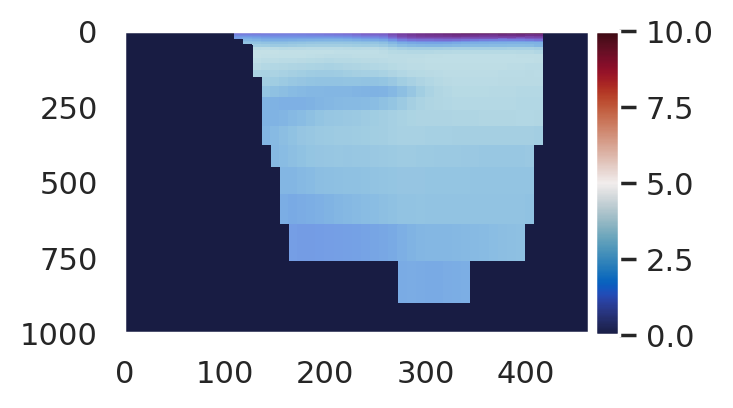

In [155]:
dmn_V11 = dmn_2015[:,P1i,P1j[0]:P1j[-1]]

fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=200)
ax.invert_yaxis()
CS1 = ax.pcolormesh(distance_V11, depths, dmn_V11*1e9, vmin=0, vmax=10, cmap=cmocean.cm.dense)
CS1 = ax.pcolormesh(distance_V11, depths, np.ma.masked_where((tmask_sub[:,P1i,P1j[0]:P1j[-1]] > 0.1), dmn_V11*1e9), \
                  vmin=0, vmax=10, cmap=cmocean.cm.balance)
ax.set_ylim([1000,0])

cbaxes = fig.add_axes([0.91, 0.12, 0.04, 0.76]) 
CBar   = fig.colorbar(CS1, cax=cbaxes)
# ax.set_title(title)